In [1]:
!pip install cupy-cuda12x

In [2]:
import numpy as np
import cupy as cp
from torch.utils.data import DataLoader
import torchvision.datasets as tv_datasets
import torchvision.transforms as tv_transforms
import matplotlib.pyplot as plt
import math

In [3]:
# 验证是否cupy成功使用了gpu
import time
# 创建大矩阵
size = 1000
# NumPy数组（CPU）
a_cpu = np.random.random((size, size))
b_cpu = np.random.random((size, size))
# CuPy数组（GPU）
a_gpu = cp.array(a_cpu)
b_gpu = cp.array(b_cpu)

# CPU计时
start_cpu = time.time()
c_cpu = np.dot(a_cpu, b_cpu)
cpu_time = time.time() - start_cpu

# GPU计时
start_gpu = time.time()
c_gpu = cp.dot(a_gpu, b_gpu)
cp.cuda.Stream.null.synchronize()  # 确保GPU运算完成
gpu_time = time.time() - start_gpu

print(f"CPU time: {cpu_time:.4f} seconds")
print(f"GPU time: {gpu_time:.4f} seconds")

CPU time: 0.0448 seconds
GPU time: 0.0972 seconds


# Basic components

In [4]:
class Module:
    @property
    def params(self):
        return []

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [5]:
class Sequential(Module, list):
    def __init__(self, *module_lst):
        super().__init__(module_lst)

    @property
    def params(self):
        return sum([m.params for m in self], [])

    def forward(self, x):
        y = x
        for module in self:
            y = module(y)
        return y

    def backward(self, dy):
        dx = dy
        for module in self[::-1]:
            dx = module.backward(dx)
        return dx

In [6]:
# 工具函数
def to_cpu(x):
    return cp.asnumpy(x) if isinstance(x, cp.ndarray) else x

def to_gpu(x):
    return cp.asarray(x) if isinstance(x, np.ndarray) else x

# NN

In [7]:
class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=False):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding if isinstance(padding, tuple) else (padding, padding)

        scale = np.sqrt(2.0 / (in_channels * np.prod(self.kernel_size)))
        self.weight = cp.random.normal(0, scale, (out_channels, in_channels, *self.kernel_size))
        self.weight_grad = cp.zeros_like(self.weight)

        if bias:
            self.bias = cp.zeros(out_channels)
        else:
            self.bias = None

    @property
    def params(self):
        return [dict(val=self.weight, grad=self.weight_grad)]

    def forward(self, x):
        self.x = x
        batch_size, _, h, w = x.shape
        pad_h, pad_w = self.padding

        if pad_h > 0 or pad_w > 0:
            x = cp.pad(x, ((0,0), (0,0), (pad_h,pad_h), (pad_w,pad_w)), 'constant')

        out_h = (h + 2 * pad_h - self.kernel_size[0]) // self.stride[0] + 1
        out_w = (w + 2 * pad_w - self.kernel_size[1]) // self.stride[1] + 1

        col = self._im2col(x,out_h,out_w)
        col_W = self.weight.reshape(self.out_channels, -1).T

        out = cp.dot(col, col_W)
        if self.bias is not None:
            out += self.bias.data
        out = out.reshape(batch_size, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.col = col
        #print('A forward::Conv2d finished.')
        return out

    def backward(self, dout):
        batch_size, channels, h, w = self.x.shape
        kh, kw = self.kernel_size
        sh, sw = self.stride
        ph,pw = self.padding

        h_out = (h + 2*ph - kh) // sh + 1
        w_out = (w + 2*pw - kw) // sw + 1

        if self.bias is not None:
            self.bias.grad = cp.sum(dout, axis=(0, 2, 3))

        dout = dout.transpose(1,0,2,3).reshape(self.out_channels, -1)

        self.weight_grad = cp.dot(dout, self.col).reshape(self.out_channels, self.in_channels, kh, kw)

        dcol = cp.dot(dout.T, self.weight.reshape(self.out_channels, -1))
        dcol = dcol.reshape(batch_size, h_out, w_out, self.in_channels, kh, kw)

        dx = self._col2im(dcol,h_out,w_out)
        # Remove padding
        if ph > 0 or pw > 0:
            dx = dx[:, :, ph:ph+h, pw:pw+w]
        #print('A backward::Conv2d finished.')

        return dx

    def _im2col(self, x,out_h,out_w):
        batch_size, channels, height, width = x.shape
        kh, kw = self.kernel_size
        sh, sw = self.stride
        ph,pw = self.padding

        x_padded = cp.pad(x, ((0, 0), (0, 0), (ph, ph), (pw, pw)), mode='constant')

        col = cp.zeros((batch_size,channels,kh,kw,out_h,out_w))

        for i in range(kh):
            h_max = i + sh * out_h
            for j in range(kw):
                w_max = j + sw * out_w
                col[:, :, i, j, :, :] = x_padded[:, :, i:h_max:sh, j:w_max:sw]
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(batch_size * out_h * out_w, -1)

        return col

    def _col2im(self, col, out_h,out_w):
        batch_size, channels, h,w = self.x.shape
        kh, kw = self.kernel_size
        sh, sw = self.stride
        ph,pw = self.padding

        img = cp.zeros((batch_size, self.in_channels, h + 2*ph, w + 2*pw))

        for y in range(out_h):
            y_start = y * sh
            y_end = y_start + kh
            for x in range(out_w):
                x_start = x * sw
                x_end = x_start + kw
                grad_patch = col[:, y, x].reshape(batch_size, self.in_channels, kh, kw)
                img[:, :, y_start:y_end, x_start:x_end] += grad_patch

        return img

In [8]:
# class Conv2d(Module):
#     def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
#         self.stride = stride if isinstance(stride, tuple) else (stride, stride)
#         self.padding = padding if isinstance(padding, tuple) else (padding, padding)

#         scale = np.sqrt(2.0 / (in_channels * np.prod(self.kernel_size)))
#         self.weight = cp.random.normal(0, scale, (out_channels, in_channels, kernel_size))
#         self.weight_grad = cp.zeros_like(self.weight)

#     @property
#     def params(self):
#         return [dict(val=self.weight, grad=self.weight_grad)]

#     def forward(self, x):
#         self.x = x
#         batch_size, _, h, w = x.shape
#         pad_h, pad_w = self.padding

#         if pad_h > 0 or pad_w > 0:
#             x = cp.pad(x, ((0,0), (0,0), (pad_h,pad_h), (pad_w,pad_w)), 'constant')

#         out_h = (h + 2 * pad_h - self.kernel_size[0]) // self.stride[0] + 1
#         out_w = (w + 2 * pad_w - self.kernel_size[1]) // self.stride[1] + 1

#         col = self._im2col(x)
#         col_W = self.weight.reshape(self.out_channels, -1).T
#         print(f"col:{col.shape}")
#         print(f"col_W:{col_W.shape}")
#         out = cp.dot(col, col_W)
#         out = out.reshape(batch_size, out_h, out_w, -1).transpose(0, 3, 1, 2)

#         self.col = col
#         return out

#     def backward(self, dout):
#         batch_size, _, h, w = dout.shape
#         dout = dout.transpose(0,2,3,1).reshape(-1, self.out_channels)

#         self.weight_grad = cp.dot(self.col.T, dout)
#         self.weight_grad = self.weight_grad.transpose(1, 0)
#         self.weight_grad = self.weight_grad.reshape(self.weight.shape)

#         dcol = cp.dot(dout, self.weight.reshape(self.out_channels, -1))
#         dx = self._col2im(dcol)

#         return dx

#     def _im2col(self, input_data):
#         batch_size, channels, height, width = input_data.shape
#         kh, kw = self.kernel_size
#         sh, sw = self.stride
#         ph, pw = self.padding

#         # 计算输出尺寸
#         out_h = (height + 2 * ph - kh) // sh + 1
#         out_w = (width + 2 * pw - kw) // sw + 1

#         # 创建输出矩阵
#         col = cp.zeros((batch_size * out_h * out_w, channels * kh * kw))

#         # 对每个滑动窗口位置进行操作
#         for h_col in range(out_h):
#             for w_col in range(out_w):
#                 # 计算输入图像上的位置
#                 h_im = h_col * sh - ph
#                 w_im = w_col * sw - pw

#                 # 对每个卷积核位置进行操作
#                 for h_offset in range(kh):
#                     h_im_pos = h_im + h_offset
#                     for w_offset in range(kw):
#                         w_im_pos = w_im + w_offset

#                         # 计算当前输出位置在col中的索引
#                         col_idx = (h_col * out_w + w_col)

#                         # 计算kernel位置在channels_col中的偏移
#                         channel_offset = (h_offset * kw + w_offset) * channels

#                         # 如果在有效区域内，复制数据
#                         if (0 <= h_im_pos < height) and (0 <= w_im_pos < width):
#                             for b in range(batch_size):
#                                 # 获取输入数据切片
#                                 input_slice = input_data[b, :, h_im_pos, w_im_pos]
#                                 # 写入col矩阵
#                                 col[b * out_h * out_w + col_idx,
#                                     channel_offset:channel_offset + channels] = input_slice

#         return col

#     def _col2im(self, col):
#         batch_size, channels, height, width = self.x.shape
#         kh, kw = self.kernel_size
#         sh, sw = self.stride
#         ph, pw = self.padding

#         # 计算输出特征图大小
#         out_h = (height + 2*ph - kh) // sh + 1
#         out_w = (width + 2*pw - kw) // sw + 1

#         # 创建输出图像，初始化为0
#         img = cp.zeros((batch_size, channels, height, width))

#         # 计算channels_col
#         channels_col = channels * kh * kw

#         # 对每个batch分别处理
#         for b in range(batch_size):
#             # 遍历展开后的通道
#             for c_col in range(channels_col):
#                 # 计算在原始图像中的位置
#                 w_offset = c_col % kw
#                 h_offset = (c_col // kw) % kh
#                 c_im = c_col // (kh * kw)

#                 # 遍历输出特征图的每个位置
#                 for h_col in range(out_h):
#                     # 计算在输入图像中的高度位置
#                     h_im = h_col * sh - ph + h_offset

#                     for w_col in range(out_w):
#                         # 计算在输入图像中的宽度位置
#                         w_im = w_col * sw - pw + w_offset

#                         if (0 <= h_im < height) and (0 <= w_im < width):
#                             # 累加贡献值
#                             img[b, c_im, h_im, w_im] += \
#                                 col[b * out_h * out_w + h_col * out_w + w_col, c_col]

#         return img

In [9]:
class BatchNorm2d(Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.training = True
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        self.gamma = cp.ones(num_features)
        self.beta = cp.zeros(num_features)
        self.gamma_grad = cp.zeros_like(self.gamma)
        self.beta_grad = cp.zeros_like(self.beta)

        self.running_mean = cp.zeros(num_features)
        self.running_var = cp.ones(num_features)

    @property
    def params(self):
        return [
            dict(val=self.gamma, grad=self.gamma_grad),
            dict(val=self.beta, grad=self.beta_grad)
        ]

    def forward(self, x):
        self.x = x
        N, C, H, W = x.shape

        if self.training:
            mu = x.mean(axis=(0,2,3), keepdims=True)
            var = x.var(axis=(0,2,3), keepdims=True) + self.eps
            std = cp.sqrt(var)

            x_norm = (x - mu) / std
            self.x_norm = x_norm

            self.running_mean = self.momentum * mu.reshape(-1) + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * var.reshape(-1) + (1 - self.momentum) * self.running_var
        else:
            x_norm = (x - self.running_mean.reshape(1,C,1,1)) / cp.sqrt(self.running_var.reshape(1,C,1,1) + self.eps)
            self.x_norm = x_norm

        out = self.gamma.reshape(1,C,1,1) * x_norm + self.beta.reshape(1,C,1,1)
        #print('A forward::BatchNorm2d finished.')
        return out

    def backward(self, dout):
        N, C, H, W = dout.shape

        self.gamma_grad = (dout * self.x_norm).sum(axis=(0,2,3))
        self.beta_grad = dout.sum(axis=(0,2,3))

        dx_norm = dout * self.gamma.reshape(1,C,1,1)
        dvar = (dx_norm * (self.x - self.x_norm.mean(axis=(0,2,3), keepdims=True)) * -0.5 *
               (self.x_norm.var(axis=(0,2,3), keepdims=True) + self.eps) ** (-3/2)).sum(axis=(0,2,3), keepdims=True)
        dmean = -dx_norm.sum(axis=(0,2,3), keepdims=True) / cp.sqrt(self.x_norm.var(axis=(0,2,3), keepdims=True) + self.eps)
        dx = dx_norm / cp.sqrt(self.x_norm.var(axis=(0,2,3), keepdims=True) + self.eps) + dvar * 2 * (self.x - self.x_norm.mean(axis=(0,2,3), keepdims=True)) / (N*H*W) + dmean / (N*H*W)

        #print('A backward::BatchNorm2d finished.')
        return dx

In [10]:
class BatchNorm1d(Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.training = True
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        self.gamma = cp.ones(num_features)
        self.beta = cp.zeros(num_features)
        self.gamma_grad = cp.zeros_like(self.gamma)
        self.beta_grad = cp.zeros_like(self.beta)

        self.running_mean = cp.zeros(num_features)
        self.running_var = cp.ones(num_features)

    @property
    def params(self):
        return [
            dict(val=self.gamma, grad=self.gamma_grad),
            dict(val=self.beta, grad=self.beta_grad)
        ]

    def forward(self, x):
        self.x = x
        if self.training:
            mu = x.mean(axis=0)
            var = x.var(axis=0) + self.eps
            std = cp.sqrt(var)

            x_norm = (x - mu) / std
            self.x_norm = x_norm

            self.running_mean = self.momentum * mu + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * var + (1 - self.momentum) * self.running_var
        else:
            x_norm = (x - self.running_mean) / cp.sqrt(self.running_var + self.eps)
            self.x_norm = x_norm

        out = self.gamma * x_norm + self.beta
        #print('A forward::BatchNorm1d finished.')
        return out

    def backward(self, dout):
        N = dout.shape[0]

        self.gamma_grad = (dout * self.x_norm).sum(axis=0)
        self.beta_grad = dout.sum(axis=0)

        dx_norm = dout * self.gamma
        dvar = (dx_norm * (self.x - self.x_norm.mean(axis=0)) * -0.5 *
               (self.x_norm.var(axis=0) + self.eps) ** (-3/2)).sum(axis=0)
        dmean = -dx_norm.sum(axis=0) / cp.sqrt(self.x_norm.var(axis=0) + self.eps)
        dx = dx_norm / cp.sqrt(self.x_norm.var(axis=0) + self.eps) + dvar * 2 * (self.x - self.x_norm.mean(axis=0)) / N + dmean / N
        #print('A backward::BatchNorm1d finished.')

        return dx

In [11]:
class ReLU(Module):
    def forward(self, x):
        self.x = x
        return cp.maximum(0, x)

    def backward(self, dout):
        return dout * (self.x > 0)

In [12]:
class Sigmoid(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.out = 1 / (1 + cp.exp(-x))
        return self.out

    def backward(self, dout):
        return dout * self.out * (1 - self.out)

In [13]:
class LeakyReLU(Module):
    def __init__(self, negative_slope=0.01):
        super().__init__()
        self.negative_slope = negative_slope

    def forward(self, x):
        self.x = x
        return cp.where(x > 0, x, x * self.negative_slope)

    def backward(self, dout):
        return cp.where(self.x > 0, dout, dout * self.negative_slope)

In [14]:
class SELU(Module):
    def __init__(self):
        super().__init__()
        self.alpha = 1.6732632423543772848170429916717
        self.scale = 1.0507009873554804934193349852946

    def forward(self, x):
        self.x = x
        return self.scale * cp.where(x > 0, x, self.alpha * (cp.exp(x) - 1))

    def backward(self, dout):
        return self.scale * cp.where(self.x > 0, dout, dout * self.alpha * cp.exp(self.x))

In [15]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride=None):
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if stride is not None else self.kernel_size
        self.stride = self.stride if isinstance(self.stride, tuple) else (self.stride, self.stride)

    def forward(self, x):
        self.x = x
        N, C, H, W = x.shape
        kh, kw = self.kernel_size
        sh, sw = self.stride

        out_h = (H - kh) // sh + 1
        out_w = (W - kw) // sw + 1

        col = cp.zeros((N * C * out_h * out_w, kh * kw))
        for y in range(out_h):
            y_start = y * sh
            for x in range(out_w):
                x_start = x * sw
                receptive_field = self.x[:, :, y_start:y_start + kh, x_start:x_start + kw]
                col[y * out_w + x::out_h * out_w] = receptive_field.reshape(N * C, -1)

        self.max_indices = col.argmax(axis=1)
        out = col[cp.arange(col.shape[0]), self.max_indices]
        #print('A forward::MaxPool2d finished.')

        return out.reshape(N, C, out_h, out_w)

    def backward(self, dout):
        N, C, H, W = self.x.shape
        kh, kw = self.kernel_size
        sh, sw = self.stride

        out_h = (H - kh) // sh + 1
        out_w = (W - kw) // sw + 1

        dx = cp.zeros_like(self.x)
        dout_flat = dout.reshape(-1)

        for i in range(dout_flat.shape[0]):
            h_idx = (i // (C * out_w)) // out_h
            w_idx = (i // C) % out_w
            c_idx = i % C
            h_start = h_idx * sh
            w_start = w_idx * sw

            max_idx = self.max_indices[i]
            h_offset = max_idx // kw
            w_offset = max_idx % kw

            dx[h_idx, c_idx, h_start + h_offset, w_start + w_offset] += dout_flat[i]
        #print('A backward::MaxPool2d finished.')

        return dx


In [16]:
class Dropout(Module):
    def __init__(self, p=0.5):
        self.p = p
        self.mask = None
        self.training = True

    def forward(self, x):
        if self.training:
            self.mask = cp.random.rand(*x.shape) > self.p
            return x * self.mask / (1 - self.p)
        #print('A forward::Dropout finished.')
        return x

    def backward(self, dout):
        #print('A backward::Dropout finished.')
        return dout * self.mask / (1 - self.p)


In [17]:
class Linear(Module):
    def __init__(self, in_features, out_features):
        scale = np.sqrt(2.0 / in_features)
        self.weight = cp.random.normal(0, scale, (out_features, in_features))
        self.bias = cp.zeros(out_features)

        self.weight_grad = cp.zeros_like(self.weight)
        self.bias_grad = cp.zeros_like(self.bias)

    @property
    def params(self):
        return [
            dict(val=self.weight, grad=self.weight_grad),
            dict(val=self.bias, grad=self.bias_grad)
        ]

    def forward(self, x):
        self.x = x
        #print('A forward::Linear finished.')
        return cp.dot(x, self.weight.T) + self.bias

    def backward(self, dout):
        self.weight_grad = cp.dot(dout.T, self.x)
        self.bias_grad = dout.sum(axis=0)
        #print('A backward::Linear finished.')
        return cp.dot(dout, self.weight)


In [18]:
class Flatten(Module):
    def forward(self, x):
        self.input_shape = x.shape
        #print('A forward::Flatten finished.')
        return x.reshape(x.shape[0], -1)

    def backward(self, dout):
        #print('A backward::Flatten finished.')
        return dout.reshape(self.input_shape)


# Loss function, optimizer, and learning rate

In [19]:
class CrossEntropyLoss(Module):
    def forward(self, x, target):
        self.x = x
        self.target = target
        batch_size = x.shape[0]

        x_shifted = x - cp.max(x, axis=1, keepdims=True)
        exp_x = cp.exp(x_shifted)
        self.softmax_x = exp_x / cp.sum(exp_x, axis=1, keepdims=True)

        loss = -cp.log(self.softmax_x[cp.arange(batch_size), target] + 1e-7)
        return loss.mean()

    def backward(self, dout=1):
        batch_size = self.x.shape[0]
        dx = self.softmax_x.copy()
        dx[cp.arange(batch_size), self.target] -= 1
        return dx * dout / batch_size


In [20]:
class FocalLoss(Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha  # 平衡因子
        self.gamma = gamma  # 聚焦参数

    def forward(self, x, target):
        self.x = x
        self.target = target
        batch_size = x.shape[0]

        # 计算softmax
        x_shifted = x - cp.max(x, axis=1, keepdims=True)
        exp_x = cp.exp(x_shifted)
        self.softmax_x = exp_x / cp.sum(exp_x, axis=1, keepdims=True)

        # 获取目标类别的预测概率
        pt = self.softmax_x[cp.arange(batch_size), target]

        # 计算focal loss
        self.pt = pt  # 保存用于反向传播
        focal_weight = (1 - pt) ** self.gamma

        # 添加alpha权重
        alpha_weight = cp.ones_like(pt) * self.alpha
        alpha_weight[target == 0] = 1 - self.alpha

        loss = -alpha_weight * focal_weight * cp.log(pt + 1e-7)
        return loss.mean()

    def backward(self, dout=1):
        batch_size = self.x.shape[0]
        dx = self.softmax_x.copy()

        pt = self.pt
        focal_weight = (1 - pt) ** self.gamma

        # 计算梯度
        for i in range(batch_size):
            target_class = self.target[i]
            alpha = self.alpha if target_class == 1 else (1 - self.alpha)
            # focal loss对softmax输出的梯度
            dx[i, target_class] -= 1
            dx[i] *= alpha * focal_weight[i] * dout / batch_size

        return dx

In [21]:
class SGD:
    def __init__(self, params, lr=0.01):
        self.params = params
        self.lr = lr

    def zero_grad(self):
        for param in self.params:
            param["grad"][:] = 0

    def step(self):
        for i, param in enumerate(self.params):
            param["val"] -= self.lr * param["grad"]

In [22]:
class AdamW:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01):
        self.params = params
        self.lr = lr  # 在LRScheduler中的optimizer.lr当中被step()修改
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay

        self.m = [cp.zeros_like(p["val"]) for p in params]
        self.v = [cp.zeros_like(p["val"]) for p in params]
        self.t = 0

    def step(self):
        self.t += 1

        for i, param in enumerate(self.params):
            g = param["grad"]

            if self.weight_decay > 0:
                g = g + self.weight_decay * param["val"]

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            mt = self.m[i] / (1 - self.beta1 ** self.t)

            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g * g)
            vt = self.v[i] / (1 - self.beta2 ** self.t)

            param["val"] -= self.lr * mt / (cp.sqrt(vt) + self.eps)

    def zero_grad(self):
        for param in self.params:
            param["grad"][:] = 0


In [23]:
class LRScheduler:
    def __init__(self, optimizer, num_epochs, warmup_epochs=None, constant_epochs=None, initial_lr=3e-4, max_lr=3e-3):
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.warmup_epochs = warmup_epochs if warmup_epochs is not None else int(0.1 * num_epochs)
        self.constant_epochs = constant_epochs if constant_epochs is not None else int(0.5 * num_epochs)
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.current_lr = initial_lr

    def step(self, epoch):
        if epoch < self.warmup_epochs:
            # Warmup阶段：线性增加学习率
            lr = self.initial_lr + (self.max_lr - self.initial_lr) * (epoch / self.warmup_epochs)
        elif epoch < self.constant_epochs:
            lr = self.max_lr
        else:
            # 后50%使用Cosine退火
            progress = (epoch - self.warmup_epochs) / (self.num_epochs - self.warmup_epochs)
            lr = self.max_lr * 0.5 * (1 + math.cos(progress * math.pi))

        self.current_lr = lr
        self.optimizer.lr = lr
        return lr


# Simplified NN for MNIST

In [24]:
def build_model():
    net = Sequential(
        Conv2d(1, 64, 3, padding=1), ReLU(), BatchNorm2d(64),
        Conv2d(64, 128, 3, padding=1), ReLU(), BatchNorm2d(128),
        Conv2d(128, 128, 3, padding=1), ReLU(), BatchNorm2d(128),
        Conv2d(128, 64, 3, padding=1), ReLU(), BatchNorm2d(64),

        Flatten(),

        Linear(64 * 28 * 28, 128), ReLU(), Dropout(0.3), BatchNorm1d(128),
        Linear(128, 64), ReLU(), Dropout(0.3), BatchNorm1d(64),
        Linear(64, 10),
    )

    return net

# Training and evaluating

In [25]:
def train(model, train_loader, test_loader, num_epochs=1, device="gpu"):
    # 初始化
    criterion = CrossEntropyLoss()
    optimizer = AdamW(model.params, lr=3e-4, weight_decay=1e-6)
    scheduler = LRScheduler(optimizer, num_epochs=num_epochs)

    # 记录训练历史
    history = {
        'train_loss': [],
        'test_acc': [],
        'learning_rates': []
    }

    # 训练循环
    for epoch in range(num_epochs):
        model.training = True
        running_loss = 0.0

        # 更新学习率
        current_lr = scheduler.step(epoch)
        history['learning_rates'].append(current_lr)

        for i, (images, targets) in enumerate(train_loader):
            # 数据转换到GPU
            if device == "gpu":
                images = to_gpu(images.numpy())
                targets = to_gpu(targets.numpy())
                #print(f'Loader {i} start and has moved to GPU.')

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, targets)
            #print(f'Loader {i} completed forward and loss.')

            # 反向传播
            model.backward(criterion.backward())
            #print(f'Loader {i} completed backward.')

            # 优化器步进
            optimizer.step()
            if i % 25 == 0 :
                print(f'Loader {i} completed update.')
            optimizer.zero_grad()

            # 统计
            running_loss += loss
            if i % 100 == 99:
                avg_loss = running_loss / 100
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {avg_loss:.3f}, LR: {current_lr:.6f}')
                history['train_loss'].append(avg_loss)
                running_loss = 0.0

        # 每个epoch结束后评估
        if (epoch + 1) % 1 == 0:
            acc = evaluate(model, test_loader, device)
            history['test_acc'].append(acc)

    return history


In [26]:
def evaluate(model, test_loader, device="gpu"):
    model.training = False
    correct = 0
    total = 0

    with cp.cuda.Device(0):
        for images, targets in test_loader:
            if device == "gpu":
                images = to_gpu(images.numpy())
                targets = to_gpu(targets.numpy())

            outputs = model(images)
            predictions = cp.argmax(outputs, axis=1)
            total += targets.size
            correct += (predictions == targets).sum()

    accuracy = 100.0 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy

# Main and data augmentation

In [27]:
import torch
if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)
    print("CUDA Device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

print(f"PyTorch Version: {torch.__version__}")
import torchvision
print(f"torchvision Version: {torchvision.__version__}")

CUDA Version: 12.1
CUDA Device: Tesla T4
PyTorch Version: 2.5.1+cu121
torchvision Version: 0.20.1+cu121


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 36.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.28MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Data has been collected.
Model built
Loader 0 completed update.
Loader 25 completed update.
Loader 50 completed update.
Loader 75 completed update.
[Epoch 1, Batch 100] Loss: 2.946, LR: 0.000300
Loader 100 completed update.
Loader 125 completed update.
Loader 150 completed update.
Loader 175 completed update.
[Epoch 1, Batch 200] Loss: 2.795, LR: 0.000300
Loader 200 completed update.
Loader 225 completed update.
Loader 250 completed update.
Loader 275 completed update.
[Epoch 1, Batch 300] Loss: 2.664, LR: 0.000300
Loader 300 completed update.
Loader 325 completed update.
Loader 350 completed update.
Loader 375 completed update.
[Epoch 1, Batch 400] Loss: 2.581, LR: 0.000300
Loader 400 completed update.
Loader 425 completed update.
Loader 450 completed update.
Loader 475 completed update.
[Epoch 1, Batch 500] Loss: 2.451, LR: 0.000300
Loader 500 completed update.
Loader 525 completed update.
Loader 550 completed update.
Loader 575 completed update.
[Epoch 1, Batch 600] Loss: 2.312, LR:

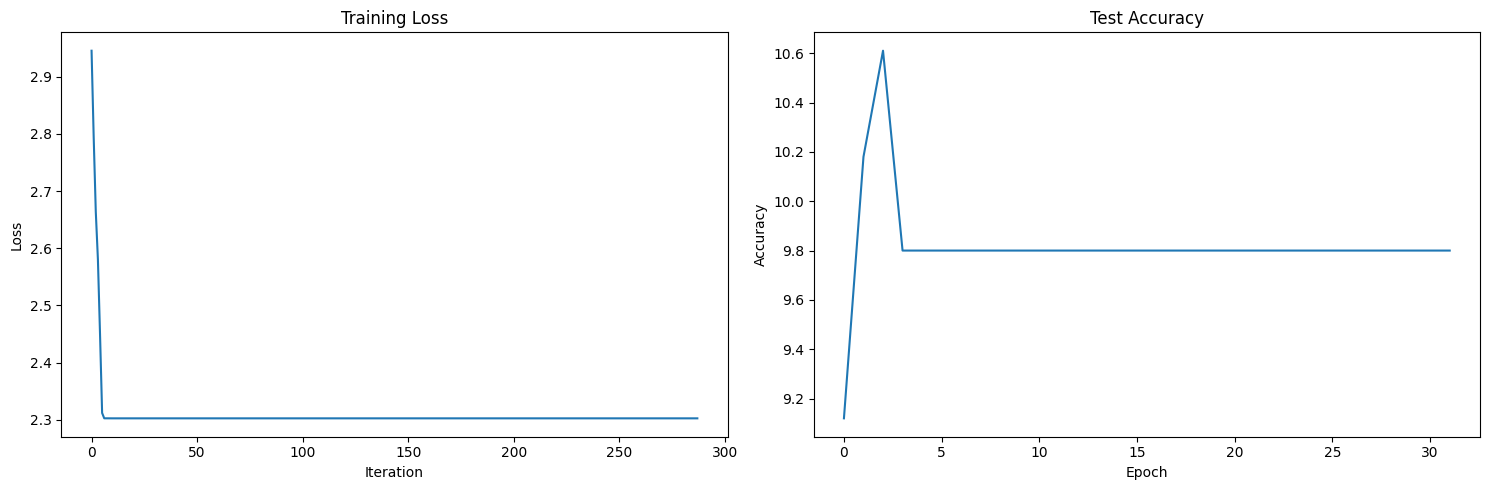

In [28]:
num_epochs=32
if __name__ == '__main__':
    # 数据增强
    transform_train = tv_transforms.Compose([
        tv_transforms.RandomCrop(28, padding=4, padding_mode='reflect'),
        tv_transforms.RandomHorizontalFlip(),
        tv_transforms.RandomRotation(degrees=15),
        tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        tv_transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        tv_transforms.ToTensor(),
        tv_transforms.Normalize((0.1307,), (0.3081,)),
        tv_transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    ])

    transform_test = tv_transforms.Compose([
        tv_transforms.ToTensor(),
        tv_transforms.Normalize((0.1307,), (0.3081,)),
    ])

    # 加载数据集
    trainset = tv_datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
    testset = tv_datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
    print('Data has been collected.')

    # 创建模型
    model = build_model()
    print('Model built')

    # 训练模型并获取历史记录
    history = train(model, train_loader, test_loader,num_epochs)
    history['train_loss'] = [float(item) for item in history['train_loss']]
    history['test_acc'] = [float(item) for item in history['test_acc']]
    
    # 绘制损失曲线
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.title('Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history['test_acc'])
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    plt.close()

In [29]:
history['test_acc']

[9.12,
 10.18,
 10.61,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8,
 9.8]

In [30]:
history['train_loss']

[2.9456232576204275,
 2.795109136405083,
 2.663832001369926,
 2.5808569213592203,
 2.450904085911643,
 2.311991942815126,
 2.3026524735373557,
 2.3025930833579804,
 2.302585126800611,
 2.3025840939994264,
 2.302584092994604,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485,
 2.3025840929945485